In [ ]:
!pip install --upgrade fastai fastcore timm kaggle pynvml nbdev -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00


In [ ]:
!pip install wandb --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00


In [ ]:
from torch import torch_version
from fastai.vision.all import *
from fastcore.parallel import *
import timm
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import wandb

In [ ]:
from pathlib import Path
base_folder = Path('/content/drive/MyDrive/data')

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
data_folder = base_folder/'datasets'/'eychallenge'

In [ ]:
model_folder = Path('/content/MyDrive/MyDrive/data/models/eychallenge')

In [ ]:
train_path = '/content/MyDrive/MyDrive/data/datasets/eychallenge/train'
test_path = '/content/MyDrive/MyDrive/data/datasets/eychallenge/test'
sub_path = '/content/MyDrive/MyDrive/data/datasets/eychallenge/sub'

In [ ]:
#mean = 
#std =

train_transforms = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor()
   #transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor()
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=test_transforms)
sub_dataset = torchvision.datasets.ImageFolder(root=sub_path, transform=test_transforms)

FileNotFoundError: ignored

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 420
    Root location: /content/MyDrive/MyDrive/data/datasets/eychallenge/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch
  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('labels:', labels)

labels: tensor([0, 0, 1, 0, 1, 0])


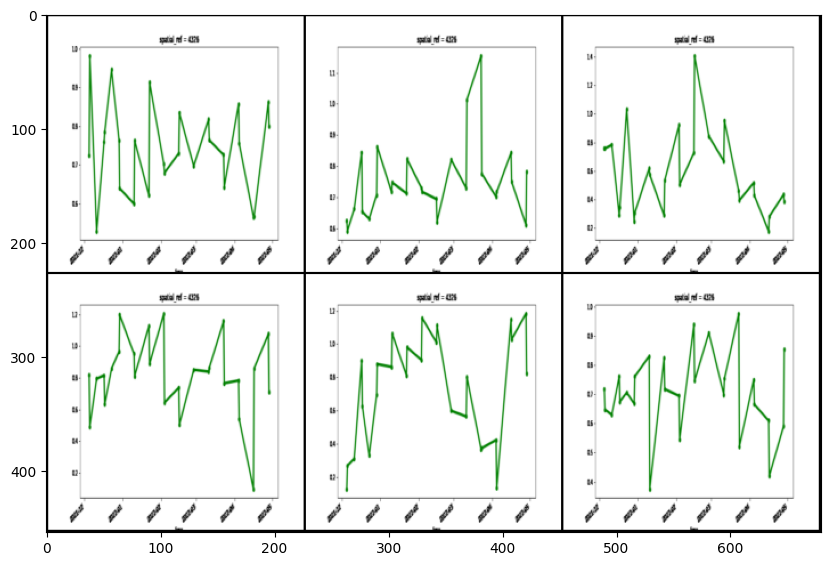

In [ ]:
show_transformed_images(train_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
sub_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=32, shuffle=False)

In [ ]:
from torch.cuda import is_available
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [ ]:
def train_model(model, train_loader, test_loader, criterian, optimizer, epoch):
  device = set_device()

  for epoch in range(epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs =  model(images)

      _, predicted = torch.max(output,1)
      loss = criterian(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      #running_correct += (labels==predicted).sum().item()
    
    epoch_loss = running_loss/len(train_loader)
    #epoch_acc = 100.0*running_correct/total

    print("   - Training datset. Got %d out of %d images correctly (%.3f%%). " #Epoch loss: %.3f
    % (running_correct, total, epoch_loss)) #epoch_acc

    evaluate_model(model, test_loader)

  print('Finished')

  return model



In [ ]:
def evaluate_model(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs =  model(images)

      _, predicted = torch.max(outputs,1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.0*predicted_correctly_on_epoch / total
    print("   - Testing datset. Got %d out of %d images correctly (%.3f%%)"
    % (predicted_correctly_on_epoch, total, epoch_acc))




In [ ]:
# learning_rate = 0.1 
# momentum = 0.9
# decay = 0.003
# epoch = 20

In [ ]:
# model = models.resnet18(pretrained = False)
# num_features =  model.fc.in_features
# num_of_classes = 2
# model.fc = nn.Linear(num_features, num_of_classes)

# device = set_device()
# model = model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=decay)




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#Model

In [ ]:
#model = models.resnet18(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
#model = torchvision.models.convnext_tiny(pretrained=True)
#model = torchvision.models.vit_b_32(pretrained=True)
#model = torchvision.models.swin_v2_t(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model

In [ ]:
model.head = nn.Linear(in_features=768, out_features=2, bias=True)

In [ ]:
model

In [ ]:
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, 2)
# model.classifier[-1].requires_grad = True
# model

In [ ]:
for params in model.parameters():
  params.requires_grad = True

In [ ]:

# # model.Linear.out_features = 2

# model.pre_logits = nn.Sequential(
#     nn.LayerNorm(model.embed_dim),
#     nn.Linear(model.embed_dim, 2)
# )

# # Freeze all layers except the classifier head
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.pre_logits.parameters():
#     param.requires_grad = True
# model

In [ ]:
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, 2)
# model.classifier[-1].requires_grad = True
# model

In [ ]:
# for name, param in model.named_parameters():
#   if 'features.4' in name or 'features.5' in name:
#     param.requires_grad = True
#   else:
#         param.requires_grad = False

In [ ]:
# for name, param in model.named_parameters():
#     if 'classifier.4' in name or 'classifier.5' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

In [ ]:
# for name, child in model.named_children():
#     if name in ['layer3', 'layer4','layer2', 'layer1']:
#         for param in child.parameters():
#           param.requires_grad = True

In [ ]:
# class CustomDeepNetwork(nn.Module):
#   def __init__(self,  input_dim, output_dim, h_sizes, dprob, non_linearity, batch_norm):
        
#     super().__init__()
#     self.input_dim = input_dim
#     self.h_sizes = h_sizes # list of hidden sizes
#     self.non_linearity = non_linearity 
#     self.batch_norm = batch_norm
#     self.dprob = dprob # list of dropout probabilities
#     self.output_dim = output_dim

#     # Initialize hidden layers  
#     model_layers = [nn.Flatten()]

#     # hidden layers
#     for i, hidden_size in enumerate(self.h_sizes):
#       model_layers.append(nn.Linear(input_dim, hidden_size))
#       model_layers.append(self.non_linearity)
#       model_layers.append(nn.Dropout(p=dprob[i]))

#       if self.batch_norm:
#         model_layers.append(nn.BatchNorm1d(hidden_size, momentum=0.9))
      
#       input_dim = hidden_size

#     # output layer  
#     model_layers.append(nn.Linear(self.h_sizes[-1], self.output_dim))

#     self.module_list = nn.ModuleList(model_layers)


#   def forward(self, x):
#     for layer in self.module_list:
#       x = layer(x)

#     # we are not using softmax function in the forward passs
#     # nn.crossentropy loss (which we will use to define our loss) combines  nn.LogSoftmax() and nn.NLLLoss() in one single class
#     return x  

In [ ]:
def train(train_loader, loss_function, model, optimizer, grad_clipping, max_norm, log_batch, log_interval):

  # Training Loop 

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_train

  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # put the model in training mode

  model.train()
  # Iterate on batches from the dataset using train_loader
  for data in train_loader:
    input_, targets = data
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)


    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Correct prediction
    _, y_pred = torch.max(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    batch_ct_train += 1

    # Step 3: Backward pass -Compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Step 4: Update the parameters
    optimizer.step()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})

  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)
  

  return train_loss, train_acc

In [ ]:
# Function for validation loop
def validate(valid_loader, loss_function, model, log_batch, log_interval):

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_valid

  # Validation/Test loop
  # Initialize valid_loss at the he strat of the epoch
  running_val_loss = 0
  running_val_correct = 0

  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for data in valid_loader:

      input_, targets = data

      # move inputs and outputs to GPUs
      input_ = input_.to(device)
      targets = targets.to(device)

      # Step 1: Forward Pass: Compute model's predictions 
      output = model(input_)

      # Step 2: Compute loss
      loss = loss_function(output, targets)

      # Correct Predictions
      _, y_pred = torch.max(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      batch_ct_valid += 1

      # Add val loss of a batch 
      running_val_loss += loss.item()

      # Add correct count for each batch
      running_val_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})

    # Calculate mean val loss for the whole dataset for a particular epoch
    val_loss = running_val_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    val_acc = running_val_correct/len(valid_loader.dataset)

    # scheduler step
    # scheduler.step(valid_loss)
    # scheduler.step()
    
  return val_loss, val_acc

In [ ]:
#Function for model training
def train_loop(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience, early_stopping,
               file_model):
    
  """ 
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # initialize variables for early stopping

  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    t0 = datetime.now()

    # Get train loss and accuracy for one epoch
    train_loss, train_acc = train(train_loader, loss_function, model, optimizer, 
                                  wandb.config.grad_clipping, wandb.config.max_norm,
                                  wandb.config.log_batch, wandb.config.log_interval)
    valid_loss, valid_acc   = validate(valid_loader, loss_function, model, wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss, "epoch": epoch})
    wandb.log({f"Train Acc :": train_acc, "epoch": epoch})

    wandb.log({f"Valid Loss :": valid_loss, "epoch": epoch})
    wandb.log({f"Valid Acc :": valid_acc, "epoch": epoch})

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True

      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    else:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')
      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss
    
    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    # print(f'Learning rate: {scheduler._last_lr[0]}')
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

In [ ]:
#function for accuracy and prediction
def get_acc_pred(data_loader, model, device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # put the model in evaluation mode
  model.eval()
  
  # Iterate over batches from data iterator
  with torch.no_grad():
    for data in data_loader:
      input_, targets = data
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      _, prediction = torch.max(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, prediction)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc  

#Meta Data

In [ ]:
#meta data
hyperparameters = SimpleNamespace(
    epochs = 10,
    input_dim = 150528,
    output_dim = 2,
    h_sizes = [100]*2  , # you can give diff values [300, 200, 100, 50]
    dprob = [0]*20,
    non_linearity = nn.ReLU(),
    batch_norm = False,
    batch_size=25,
    learning_rate=0.025,
    #dataset="CIFACR10",
    architecture="MLP",
    log_interval = 1,
    log_batch = True,
    file_model = model_folder/'ey_dsc.pt',
    grad_clipping = False, # DO NOT CHANGE hyperparameters below this 
    early_stopping = False,
    max_norm = 1,
    momentum = 0.9,
    patience = 3,
    # scheduler_factor = 0.5,
    # scheduler_patience = 0,
    weight_decay = 0.00
    )

In [ ]:
#over fit small data set
# Initialize a new project
wandb.init(name = "EY", project = 'EY-DSC' )

Train Acc :,▂▂█▂▅▅▅▃▃▁
Train Batch Acc :,▃▇█▅▆▅▂▅▅█▄▆▇▁▇▃█▅▇▆▆▆▆▆▆▄▆▄▃▄▅▃▆▄█▄▃▃▃▆
Train Batch Loss :,█▁▁▃▅▂▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▃▅▅▂
Train Loss :,▇▄▅▁▂▆▁▂▃█
Valid Acc :,▁▁▁▁▁▁▁▁▁▁
Valid Batch Accuracy :,██▁▁██▁▁██▁▁██▁▁██▁▁▁▁██▁▁████▁▁▁▁████▁▁
Valid Batch Loss :,▁▁██▁▁▇▇▃▃▅▅▃▃▄▄▂▂▆▆▆▆▂▂▄▄▄▄▃▃▄▄▆▆▂▂▃▃▅▅
Valid Loss :,█▆▂▁▄▁▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Train Acc :,0.45714
Train Batch Acc :,0.55


In [ ]:
wandb.config = hyperparameters
wandb.config

namespace(epochs=10,
          input_dim=150528,
          output_dim=2,
          h_sizes=[100, 100],
          dprob=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          non_linearity=ReLU(),
          batch_norm=False,
          batch_size=25,
          learning_rate=0.025,
          architecture='MLP',
          log_interval=1,
          log_batch=True,
          file_model=Path('/content/MyDrive/MyDrive/data/models/eychallenge/ey_dsc.pt'),
          grad_clipping=False,
          early_stopping=False,
          max_norm=1,
          momentum=0.9,
          patience=3,
          weight_decay=0.0)

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=wandb.config.batch_size, shuffle = False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

wandb.config.device = device

#model = CustomDeepNetwork(wandb.config.input_dim, wandb.config.output_dim, wandb.config.h_sizes, 
                          #wandb.config.dprob, wandb.config.non_linearity, wandb.config.batch_norm)

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
def init_weights(layer):
  if type(layer) == nn.Linear:
    #torch.nn.init.kaiming_normal_(layer.weight)
    torch.nn.init.xavier_uniform(layer.weight)
    # torch.nn.init.normal_(layer.weight, mean = 0, std = 0.001)
    torch.nn.init.zeros_(layer.bias)

model.to(wandb.config.device)
# model.apply(init_weights)

# loss_function
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr = wandb.config.learning_rate, 
                            momentum = wandb.config.momentum,
                            weight_decay = wandb.config.weight_decay)

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor, 
#                              patience=wandb.config.scheduler_patience, verbose=True)

#scheduler = StepLR(optimizer, gamma=0.4,step_size=1, verbose=True)

SANITY CHECK

In [ ]:
i = 0
for data in train_loader:
  input_, targets = data
  
  # move inputs and outputs to GPUs
  input_ = input_.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input_)
  loss = loss_function(output, targets)
  print(f'Actual loss: {loss}')
  i += 1

  if i >2:
    break
 
print(input_.shape)
print(f'Expected Theoretical loss: {np.log(10)}')

Actual loss: 14.5631742477417
Actual loss: 15.384881973266602
Actual loss: 14.684828758239746
torch.Size([25, 3, 224, 224])
Expected Theoretical loss: 2.302585092994046


#Training model

In [ ]:
#wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

In [ ]:
# See live graphs in the notebook.
#%%wandb 
batch_ct_train, batch_ct_valid = 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader, 
                                                                                          valid_loader, 
                                                                                          model, 
                                                                                          optimizer, 
                                                                                          loss_function, 
                                                                                          wandb.config.epochs, 
                                                                                          wandb.config.device,
                                                                                          wandb.config.patience,
                                                                                          wandb.config.early_stopping,
                                                                                          wandb.config.file_model,
                                                                                          )

Validation loss has decreased (inf --> 153.175436). Saving Model...
Epoch : 1 / 10
Time to complete 1 is 0:00:11.024309
Train Loss:  0.9173 | Train Accuracy:  84.5238%
Valid Loss:  153.1754 | Valid Accuracy:  52.2222%

Validation loss has decreased (153.175436 --> 1.060428). Saving model...
Epoch : 2 / 10
Time to complete 2 is 0:00:10.577141
Train Loss:  0.1175 | Train Accuracy:  96.4286%
Valid Loss:  1.0604 | Valid Accuracy:  82.2222%

Validation loss has decreased (1.060428 --> 0.191859). Saving model...
Epoch : 3 / 10
Time to complete 3 is 0:00:10.986418
Train Loss:  0.0751 | Train Accuracy:  96.4286%
Valid Loss:  0.1919 | Valid Accuracy:  94.4445%

Validation loss has not decreased (0.191859 --> 0.413901). Not Saving Model...
Epoch : 4 / 10
Time to complete 4 is 0:00:13.269755
Train Loss:  0.0557 | Train Accuracy:  98.5714%
Valid Loss:  0.4139 | Valid Accuracy:  91.1111%

Validation loss has not decreased (0.191859 --> 0.387989). Not Saving Model...
Epoch : 5 / 10
Time to complete 

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define the ImageFolderDataset class
class ImageFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.filenames = os.listdir(root)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img_path = os.path.join(self.root, filename)
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.filenames)

In [ ]:
sub_path = '/content/MyDrive/MyDrive/data/datasets/eychallenge/sub'

In [ ]:
sub_dataset = ImageFolderDataset(sub_path, transform=train_transforms)
sub_loader = DataLoader(sub_dataset, batch_size=1, shuffle=False)

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=test_transforms)

In [ ]:
sub_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=32, shuffle=False)

In [ ]:
for images in sub_loader:
  print((images[0]).shape)

torch.Size([4, 4, 224, 224])


In [ ]:
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series.values})